In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor
from matplotlib import pyplot
import shap

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
import gc
import json
pd.set_option('display.max_columns', 1000)

/kaggle/input/data-science-bowl-2019/train.csv
/kaggle/input/data-science-bowl-2019/specs.csv
/kaggle/input/data-science-bowl-2019/train_labels.csv
/kaggle/input/data-science-bowl-2019/test.csv
/kaggle/input/data-science-bowl-2019/sample_submission.csv


# Objective

* In the last notebook we create our baseline model including a feature selection part. 
* Cohen cappa score of 0.456 (lb) with a local cv score of 0.529
* In this notebook we are going to add more features and remove others that i think they overfitt the train set and then check if our local cv score improve.
* Next, we will check if this improvement aligns with the lb.

# Notes
* Check the distribution of the target variable of the out of folds score and the prediction distribution. A good model should more or less have the same distribution.

In [2]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [3]:
def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

In [4]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv('/kaggle/input/data-science-bowl-2019/specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv('/kaggle/input/data-science-bowl-2019/sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

In [5]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

In [6]:
# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
        
    # last features
    sessions_count = 0
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
                    
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            features['installation_session_count'] = sessions_count
            
            variety_features = [('var_event_code', event_code_count),
                              ('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count)]
            
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
                 
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        sessions_count += 1
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [7]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

In [8]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.cv = self.get_cv()
        self.verbose = verbose
        self.params = self.get_params()
        self.y_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(reduce_train), ))
        y_pred = np.zeros((len(reduce_test), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = eval_qwk_lgb_regr(self.train_df[self.target], oof_pred)
        if self.verbose:
            print('Our oof cohen kappa score is: ', loss_score)
        return y_pred, loss_score, model

In [9]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100
                    }
        return params

In [10]:
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(self.params, train_set, 
                         num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], 
                         verbose_eval=verbosity, early_stopping_rounds=100)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)
        
    def get_params(self):
        params = {'colsample_bytree': 0.8,                 
            'learning_rate': 0.01,
            'max_depth': 10,
            'subsample': 1,
            'objective':'reg:squarederror',
            #'eval_metric':'rmse',
            'min_child_weight':3,
            'gamma':0.25,
            'n_estimators':5000}

        return params

In [11]:
class Catb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        clf = CatBoostRegressor(**self.params)
        clf.fit(train_set['X'], 
                train_set['y'], 
                eval_set=(val_set['X'], val_set['y']),
                verbose=verbosity, 
                cat_features=self.categoricals)
        return clf
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        params = {'loss_function': 'RMSE',
                   'task_type': "CPU",
                   'iterations': 5000,
                   'od_type': "Iter",
                    'depth': 10,
                  'colsample_bylevel': 0.5, 
                   'early_stopping_rounds': 300,
                    'l2_leaf_reg': 18,
                   'random_seed': 42,
                    'use_best_model': True
                    }
        return params

In [12]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

class Nn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.active_features_]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        print(train_df[features].shape)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(train_set['X'].shape[1],)),
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(50, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(25, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='relu')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

In [13]:
from random import choice

class Cnn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.active_features_]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        self.create_feat_2d(features)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def create_feat_2d(self, features, n_feats_repeat=50):
        self.n_feats = len(features)
        self.n_feats_repeat = n_feats_repeat
        self.mask = np.zeros((self.n_feats_repeat, self.n_feats), dtype=np.int32)
        for i in range(self.n_feats_repeat):
            l = list(range(self.n_feats))
            for j in range(self.n_feats):
                c = l.pop(choice(range(len(l))))
                self.mask[i, j] = c
        self.mask = tf.convert_to_tensor(self.mask)
        print(self.mask.shape)
       
        
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0

        inp = tf.keras.layers.Input(shape=(self.n_feats))
        x = tf.keras.layers.Lambda(lambda x: tf.gather(x, self.mask, axis=1))(inp)
        x = tf.keras.layers.Reshape((self.n_feats_repeat, self.n_feats, 1))(x)
        x = tf.keras.layers.Conv2D(18, (50, 50), strides=50, activation='relu')(x)
        x = tf.keras.layers.Flatten()(x)
        #x = tf.keras.layers.Dense(200, activation='relu')(x)
        #x = tf.keras.layers.LayerNormalization()(x)
        #x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(100, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(50, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        out = tf.keras.layers.Dense(1)(x)
        
        model = tf.keras.Model(inp, out)
    
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

In [14]:
# read data
train, test, train_labels, specs, sample_submission = read_data()
# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)
# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = get_train_and_test(train, test)

del train, test

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


0.0026939774600629332


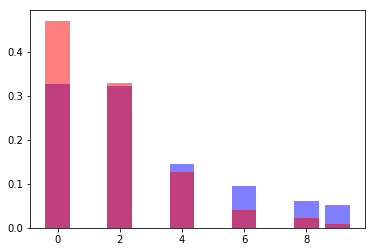

0.0026939774600629332

In [15]:
def stract_hists(feature, train=reduce_train, test=reduce_test, adjust=False, plot=False):
    n_bins = 10
    train_data = train[feature]
    test_data = test[feature]
    if adjust:
        test_data *= train_data.mean() / test_data.mean()
    perc_90 = np.percentile(train_data, 95)
    train_data = np.clip(train_data, 0, perc_90)
    test_data = np.clip(test_data, 0, perc_90)
    train_hist = np.histogram(train_data, bins=n_bins)[0] / len(train_data)
    test_hist = np.histogram(test_data, bins=n_bins)[0] / len(test_data)
    msre = mean_squared_error(train_hist, test_hist)
    if plot:
        print(msre)
        plt.bar(range(n_bins), train_hist, color='blue', alpha=0.5)
        plt.bar(range(n_bins), test_hist, color='red', alpha=0.5)
        plt.show()
    return msre
stract_hists('Magma Peak - Level 1_2000', adjust=False, plot=True)

In [16]:
# call feature engineering function
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]

In [17]:
counter = 0
to_remove = []
for feat_a in features:
    for feat_b in features:
        if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
            c = np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1]
            if c > 0.995:
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

1: FEAT_A: Clip FEAT_B: 27253bdc - Correlation: 1.0
2: FEAT_A: 2050 FEAT_B: 2040 - Correlation: 0.9965259434878121
3: FEAT_A: 2050 FEAT_B: 37c53127 - Correlation: 1.0
4: FEAT_A: 2050 FEAT_B: 26fd2d99 - Correlation: 0.9965084543995752
5: FEAT_A: 2050 FEAT_B: dcaede90 - Correlation: 0.9965259434878121
6: FEAT_A: 2050 FEAT_B: 73757a5e - Correlation: 0.9998050146714003
7: FEAT_A: 2050 FEAT_B: 08fd73f3 - Correlation: 0.9966123918733659
8: FEAT_A: 2050 FEAT_B: 2b9272f4 - Correlation: 0.9999839030068793
9: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2040 - Correlation: 0.9965259434878121
10: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3021 - Correlation: 0.9998050146714003
11: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2030 - Correlation: 0.9966123918733659
12: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2050 - Correlation: 1.0
13: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2020 - Correlation: 0.9965084543995752
14: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3121 - Correlation: 0.9999839030068793
15: FEAT_A: 4230 FEAT_B: 4235 - Correlation: 0.99999951974

In [18]:
to_exclude = [] 
ajusted_test = reduce_test.copy()
for feature in ajusted_test.columns:
    if feature not in ['accuracy_group', 'installation_id', 'accuracy_group', 'session_title']:
        data = reduce_train[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)

acc_Cart Balancer (Assessment) -0.04020325710970116 -0.47065833333333346 0.006732930476733109
13f56524 0.04392312040700961 0.0
7fd1ac25 0.01978518937252685 0.0
1b54d27f 0.0007348784624081402 0.0
ab4ec3a4 0.0009044657998869418 0.0
119b5b02 0.0002826455624646693 0.0
ecc6157f 0.007292255511588468 0.0
0ce40006 0.0008479366873940079 0.0
4074bac2 0.0 0.0
003cd2ee 0.0 0.0
6aeafed4 0.14703222159412097 0.008 0.0
611485c5 0.0013566986998304127 0.0
17ca3959 0.0 0.0
29a42aea 0.004070096099491238 0.0
5dc079d8 0.0 0.0
a8cc6fec 0.0 0.0
bfc77bd6 0.012832108535895986 0.0
dcb1663e 0.0 0.0
e4d32835 0.0013001695873374789 0.0
2ec694de 0.008988128886376484 0.0
eb2c19cd 0.17382702091577162 0.008 0.0
01ca3a3c 0.0004522328999434709 0.0
Crystals Rule_2010 0.0 0.0
Bug Measurer (Activity)_4080 0.008988128886376484 0.0
Fireworks (Activity)_4080 0.0013566986998304127 0.0
Pan Balance_2010 0.0 0.0
Egg Dropper (Activity)_4080 0.01978518937252685 0.0
Pan Balance_4080 0.0013001695873374789 0.0
Cart Balancer (Assessment)

In [19]:
features = [x for x in features if x not in (to_exclude + to_remove)]
reduce_train[features].shape

(17690, 364)

In [20]:
features = [x for x in features if x not in (to_exclude + to_remove)]
reduce_train[features].shape
reduce_test_save = reduce_test.copy()
reduce_train_save = reduce_train.copy()
ajusted_test_save = ajusted_test.copy()

In [21]:
dfs = np.split(reduce_train_save, [8845], axis=0)
reduce_train = dfs[0]
reduce_test = dfs[1].reset_index()
ajusted_test = dfs[1].reset_index()

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01658	valid_1's rmse: 1.06782
[200]	training's rmse: 0.933419	valid_1's rmse: 1.02475
[300]	training's rmse: 0.88722	valid_1's rmse: 1.01129
[400]	training's rmse: 0.854446	valid_1's rmse: 1.00567
[500]	training's rmse: 0.827057	valid_1's rmse: 1.00371
[600]	training's rmse: 0.80398	valid_1's rmse: 1.00348
[700]	training's rmse: 0.783258	valid_1's rmse: 1.00264
Early stopping, best iteration is:
[699]	training's rmse: 0.783456	valid_1's rmse: 1.0026
Partial score of fold 0 is: 0.5803167101501288
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01961	valid_1's rmse: 1.05406
[200]	training's rmse: 0.936614	valid_1's rmse: 1.00651
[300]	training's rmse: 0.890326	valid_1's rmse: 0.99216
[400]	training's rmse: 0.856791	valid_1's rmse: 0.987368
[500]	training's rmse: 0.829146	valid_1's rmse: 0.986467
[600]	training's rmse: 0.805124	valid_1's rmse: 0.986765
Early stoppi

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.84776	val-rmse:1.8488
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.968904	val-rmse:1.17818
[200]	train-rmse:0.646335	val-rmse:1.05265
[300]	train-rmse:0.520507	val-rmse:1.03527
[400]	train-rmse:0.4566	val-rmse:1.03281
[500]	train-rmse:0.418349	val-rmse:1.03247
Stopping. Best iteration:
[468]	train-rmse:0.427934	val-rmse:1.03244

Partial score of fold 0 is: 0.5432018613878953
[0]	train-rmse:1.84765	val-rmse:1.84871
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.970665	val-rmse:1.15964
[200]	train-rmse:0.654996	val-rmse:1.02388
[300]	train-rmse:0.526068	val-rmse:1.00384
[400]	train-rmse:0.463325	val-rmse:1.00335
Stopping. Best iteration:
[344]	train-rmse:0.492384	val-rmse:1.00249

Partial score of fold 1 is: 0.5746067334174774
[0]	train-rmse:1.8

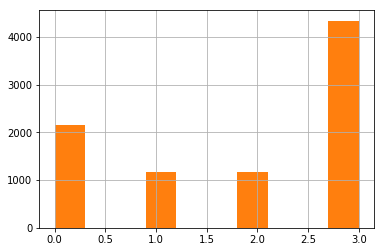

In [22]:
#cat_model = Catb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
lgb_model = Lgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
xgb_model = Xgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:100: DeprecationWarning: The ``active_features_`` attribute was deprecated in version 0.20 and will be removed 0.22.
  warnings.warn(msg, category=DeprecationWarning)


(8845, 369)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               74000     
_________________________________________________________________
layer_normalization (LayerNo (None, 200)               400       
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
layer_normalization_1 (Layer (None, 100)               200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)     

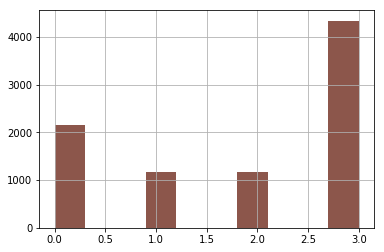

In [23]:
#cnn_model = Cnn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
nn_model = Nn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

In [24]:
XGB_pred = xgb_model.y_pred
LGBM_pred = lgb_model.y_pred
NN_pred = nn_model.y_pred
stack_Predictions = np.column_stack((XGB_pred, LGBM_pred, NN_pred))

In [25]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.cv = self.get_cv()
        self.verbose = verbose
        self.params = self.get_params()
        self.y_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(reduce_train), ))
        y_pred = np.zeros((len(ajusted_test_save), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            print(self.test_df[self.features].shape)
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            print(self.test_df[self.features].shape)
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = eval_qwk_lgb_regr(self.train_df[self.target], oof_pred)
        if self.verbose:
            print('Our oof cohen kappa score is: ', loss_score)
        return y_pred, loss_score, model
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100
                    }
        return params
    
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(self.params, train_set, 
                         num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], 
                         verbose_eval=verbosity, early_stopping_rounds=100)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)
        
    def get_params(self):
        params = {'colsample_bytree': 0.8,                 
            'learning_rate': 0.01,
            'max_depth': 10,
            'subsample': 1,
            'objective':'reg:squarederror',
            #'eval_metric':'rmse',
            'min_child_weight':3,
            'gamma':0.25,
            'n_estimators':5000}

        return params
    
class Catb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        clf = CatBoostRegressor(**self.params)
        clf.fit(train_set['X'], 
                train_set['y'], 
                eval_set=(val_set['X'], val_set['y']),
                verbose=verbosity, 
                cat_features=self.categoricals)
        return clf
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        params = {'loss_function': 'RMSE',
                   'task_type': "CPU",
                   'iterations': 5000,
                   'od_type': "Iter",
                    'depth': 10,
                  'colsample_bylevel': 0.5, 
                   'early_stopping_rounds': 300,
                    'l2_leaf_reg': 18,
                   'random_seed': 42,
                    'use_best_model': True
                    }
        return params
    
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

class Nn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.active_features_]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.fit_transform(test_df[features])
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(train_set['X'].shape[1],)),
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(50, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(25, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='relu')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None
    
from random import choice

class Cnn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.active_features_]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        self.create_feat_2d(features)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def create_feat_2d(self, features, n_feats_repeat=50):
        self.n_feats = len(features)
        self.n_feats_repeat = n_feats_repeat
        self.mask = np.zeros((self.n_feats_repeat, self.n_feats), dtype=np.int32)
        for i in range(self.n_feats_repeat):
            l = list(range(self.n_feats))
            for j in range(self.n_feats):
                c = l.pop(choice(range(len(l))))
                self.mask[i, j] = c
        self.mask = tf.convert_to_tensor(self.mask)
        print(self.mask.shape)
       
        
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0

        inp = tf.keras.layers.Input(shape=(self.n_feats))
        x = tf.keras.layers.Lambda(lambda x: tf.gather(x, self.mask, axis=1))(inp)
        x = tf.keras.layers.Reshape((self.n_feats_repeat, self.n_feats, 1))(x)
        x = tf.keras.layers.Conv2D(18, (50, 50), strides=50, activation='relu')(x)
        x = tf.keras.layers.Flatten()(x)
        #x = tf.keras.layers.Dense(200, activation='relu')(x)
        #x = tf.keras.layers.LayerNormalization()(x)
        #x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(100, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(50, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        out = tf.keras.layers.Dense(1)(x)
        
        model = tf.keras.Model(inp, out)
    
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

(1000, 364)


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01658	valid_1's rmse: 1.06782
[200]	training's rmse: 0.933419	valid_1's rmse: 1.02475
[300]	training's rmse: 0.88722	valid_1's rmse: 1.01129
[400]	training's rmse: 0.854446	valid_1's rmse: 1.00567
[500]	training's rmse: 0.827057	valid_1's rmse: 1.00371
[600]	training's rmse: 0.80398	valid_1's rmse: 1.00348
[700]	training's rmse: 0.783258	valid_1's rmse: 1.00264
Early stopping, best iteration is:
[699]	training's rmse: 0.783456	valid_1's rmse: 1.0026
(1000, 364)
Partial score of fold 0 is: 0.5803167101501288
(1000, 364)
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01961	valid_1's rmse: 1.05406
[200]	training's rmse: 0.936614	valid_1's rmse: 1.00651
[300]	training's rmse: 0.890326	valid_1's rmse: 0.99216
[400]	training's rmse: 0.856791	valid_1's rmse: 0.987368
[500]	training's rmse: 0.829146	valid_1's rmse: 0.986467
[600]	training's rmse: 0.805124	valid_1's rms

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	train-rmse:0.968904	val-rmse:1.17818
[200]	train-rmse:0.646335	val-rmse:1.05265
[300]	train-rmse:0.520507	val-rmse:1.03527
[400]	train-rmse:0.4566	val-rmse:1.03281
[500]	train-rmse:0.418349	val-rmse:1.03247
Stopping. Best iteration:
[468]	train-rmse:0.427934	val-rmse:1.03244

(1000, 364)
Partial score of fold 0 is: 0.5432018613878953
(1000, 364)
[0]	train-rmse:1.84765	val-rmse:1.84871
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.970665	val-rmse:1.15964
[200]	train-rmse:0.654996	val-rmse:1.02388
[300]	train-rmse:0.526068	val-rmse:1.00384
[400]	train-rmse:0.463325	val-rmse:1.00335
Stopping. Best iteration:
[344]	train-rmse:0.492384	val-rmse:1.00249

(1000, 364)
Partial score of fold 1 is: 0.5746067334174774
(1000, 364)
[0]	train-rmse:1.8476	val-rmse:1.84907
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse h

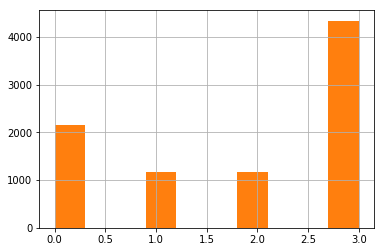

In [26]:
lgb_model_test = Lgb_Model(reduce_train, ajusted_test_save, features, categoricals=categoricals)
xgb_model_test = Xgb_Model(reduce_train, ajusted_test_save, features, categoricals=categoricals)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:100: DeprecationWarning: The ``active_features_`` attribute was deprecated in version 0.20 and will be removed 0.22.
  warnings.warn(msg, category=DeprecationWarning)


(1000, 369)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 200)               74000     
_________________________________________________________________
layer_normalization_20 (Laye (None, 200)               400       
_________________________________________________________________
dropout_20 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 100)               20100     
_________________________________________________________________
layer_normalization_21 (Laye (None, 100)               200       
_________________________________________________________________
dropout_21 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 50)   

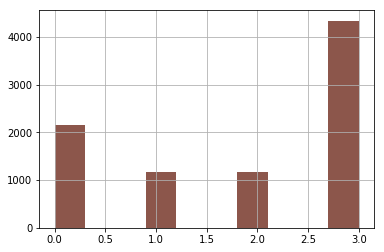

In [27]:
nn_model_test = Nn_Model(reduce_train, ajusted_test_save, features, categoricals=categoricals)

In [28]:
XGB_pred_test = xgb_model_test.y_pred
LGBM_pred_test = lgb_model_test.y_pred
NN_pred_test = nn_model_test.y_pred
stack_test_Predictions = np.column_stack((XGB_pred_test, LGBM_pred_test, NN_pred_test))

In [29]:
stack_test_Predictions_df = pd.DataFrame(stack_test_Predictions) 
stack_Predictions_df = pd.DataFrame(stack_Predictions) 
stack_Predictions_df['accuracy_group'] = ajusted_test['accuracy_group']

In [30]:
meta_model1 = xgb.XGBRegressor(colsample_bytree=0.8,
                 gamma=0.25,                 
                 learning_rate=0.01,
                 max_depth=10,
                 min_child_weight=3,
                 n_estimators=5000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=1,
                 seed=42,
                 objective='reg:squarederror') 

In [31]:
meta_model1.fit(stack_Predictions_df.drop(['accuracy_group'], axis = 1), stack_Predictions_df['accuracy_group'])
final_xgb = meta_model1.predict(stack_test_Predictions_df)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [32]:
params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.9,
                    'max_depth': 5,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    }
meta_model2 = lgb.LGBMRegressor(**params)

In [33]:
meta_model2.fit(stack_Predictions_df.drop(['accuracy_group'], axis = 1), stack_Predictions_df['accuracy_group'])
final_lgb = meta_model2.predict(stack_test_Predictions_df)

In [34]:
final_pred = 0.7 *  final_lgb + 0.3 * final_xgb 

In [35]:
# weights = {'lbg': 0.60, 'cat': 0, 'xgb': 0.20, 'nn': 0.20}

# final_pred = (lgb_model.y_pred * weights['lbg']) + (xgb_model.y_pred * weights['xgb']) + (nn_model.y_pred * weights['nn'])
# #final_pred = cnn_model.y_pred
# print(final_pred.shape)

In [36]:
#pd.DataFrame([(round(a, 2), round(b, 2), round(c, 2), round(d, 2)) for a, b, c, d in zip(lgb_model.y_pred, cat_model.y_pred, xgb_model.y_pred, nn_model.y_pred)], columns=['lgb', 'cat', 'xgb', 'nn']).head(50)

{0: 1.1996502138156706, 1: 1.6857106777756576, 2: 1.9698082736635654}


3    0.491
0    0.244
1    0.133
2    0.132
Name: accuracy_group, dtype: float64

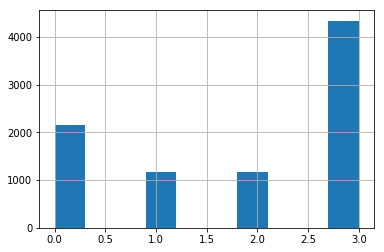

In [37]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))

sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True)